In [100]:
# allow import data
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [101]:
!ls german-traffic-signs
# note that the data are all pickled

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import cv2

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

In [0]:
np.random.seed(0)

In [104]:
# reading all data as binary
with open("german-traffic-signs/test.p", "rb") as f: 
    test_data = pickle.load(f)
with open("german-traffic-signs/train.p", "rb") as f:
    train_data = pickle.load(f)
with open("german-traffic-signs/valid.p", "rb") as f:
    val_data = pickle.load(f)
    
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

<class 'dict'>


In [105]:
# get familiar with the structure
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
# check dimensions
assert(X_train.shape[0] == y_train.shape[0]), "Stop"
assert(X_test.shape[0] == y_test.shape[0]), "Stop"
assert(X_val.shape[0] == y_val.shape[0]), "Stop"
assert(X_train.shape[1:] == (32,32,3)), "Stop"
assert(X_test.shape[1:] == (32,32,3)), "Stop"
assert(X_val.shape[1:] == (32,32,3)), "Stop"

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


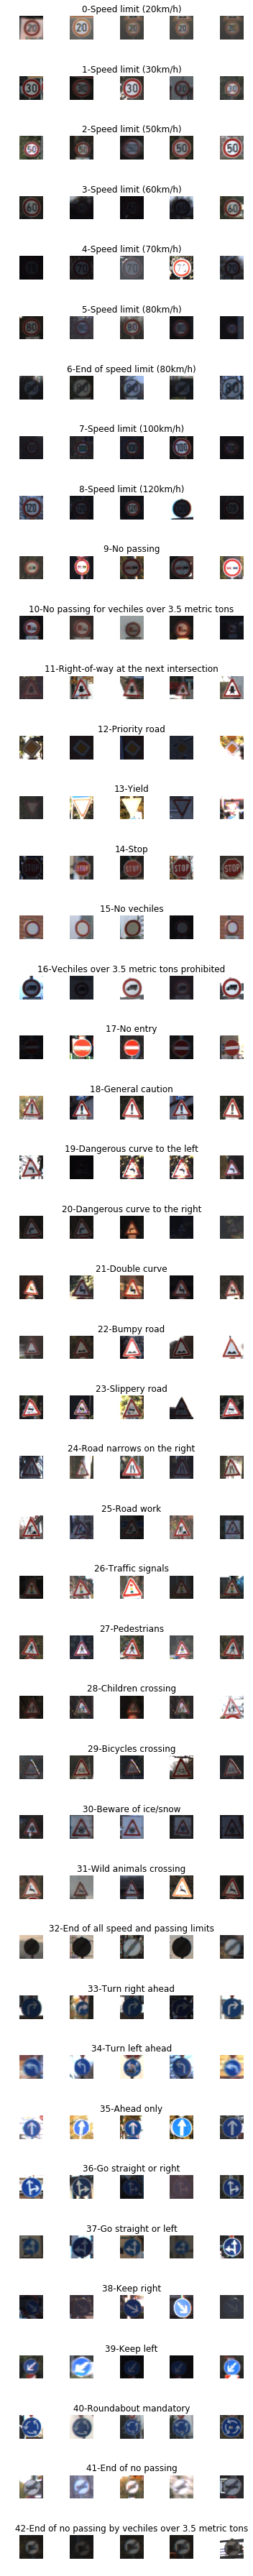

In [107]:
# matplotlib is the hardest programming language
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data.head())

num_of_samples=[]

cols = 5
num_classes = 43

# each class 5 columns
fig, axes = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows(): # (index, series)
        x_selected = X_train[y_train == j]
        axes[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)), :,:], cmap=plt.get_cmap("gray"))
        axes[j][i].axis("off")
        if i == 2:
            axes[j][i].set_title(str(j)+"-"+row["SignName"])
            num_of_samples.append(len(x_selected))
        

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


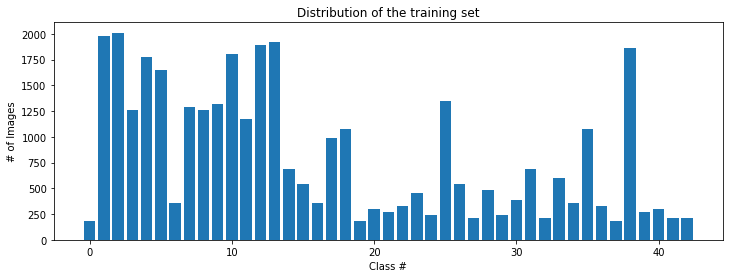

In [108]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training set")
plt.xlabel("Class #")
plt.ylabel("# of Images")
plt.show()
# shows the amount of dataset is quite nonuniform

(32, 32)


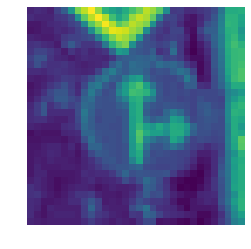

In [109]:
# color is not an important feature to look for
# traffic signs do not have the same shape (color blind people)
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

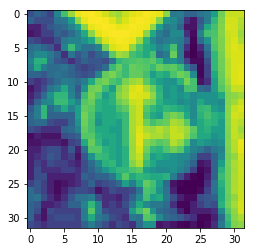

In [110]:
# histogram equalization, reassign intensities more uniformly
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)

In [0]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255.0
    return img

# preprocess training set
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1,rotation_range=10)

datagen.fit(X_train)

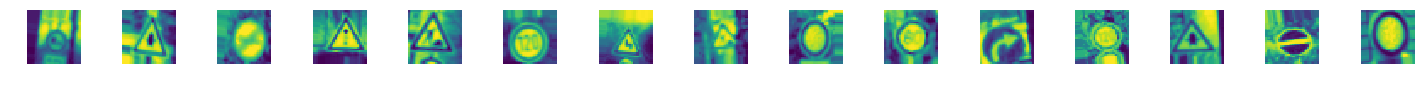

In [114]:
batches = datagen.flow(X_train, y_train, batch_size=32)
X_batch, y_batch = next(batches)

fig, axes = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axes[i].imshow(X_batch[i].reshape(32,32))
    axes[i].axis("off")

In [115]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
# one hot vector encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def model():
    model = Sequential()
    model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
    model.add(Conv2D(60,(5,5),activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(30,(3,3),activation="relu"))
    model.add(Conv2D(30,(3,3),activation="relu"))
    model.add(MaxPooling2D())   
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])
    return model

In [118]:
model = model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 480)               0         
__________

In [119]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val,y_val), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 59s 30ms/step - loss: 0.8988 - acc: 0.7365 - val_loss: 0.0852 - val_acc: 0.9737
Epoch 2/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.2103 - acc: 0.9349 - val_loss: 0.0533 - val_acc: 0.9823
Epoch 3/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.1406 - acc: 0.9556 - val_loss: 0.0481 - val_acc: 0.9850
Epoch 4/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1114 - acc: 0.9658 - val_loss: 0.0398 - val_acc: 0.9878
Epoch 5/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0946 - acc: 0.9713 - val_loss: 0.0287 - val_acc: 0.9909
Epoch 6/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0853 - acc: 0.9737 - val_loss: 0.0159 - val_acc: 0.9946
Epoch 7/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0715 - acc: 0.9776 - val_loss: 0.0212 - val_acc: 0.9943
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

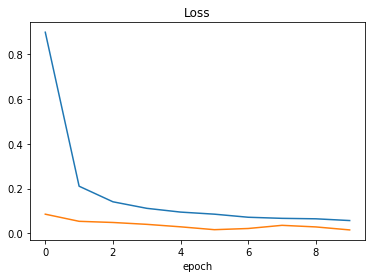

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

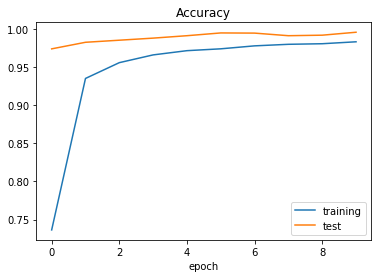

In [121]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)

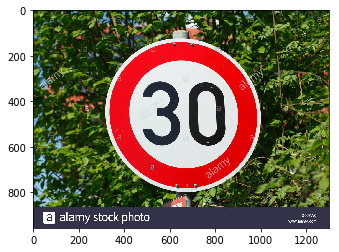

In [123]:
import requests
from PIL import Image
url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
# try

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap("gray"))

(32, 32)


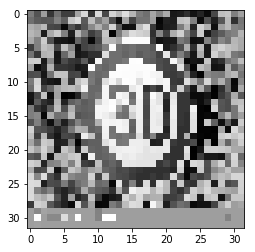

In [124]:
img = np.asarray(img)
img = cv2.resize(img, (32,32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1,32,32,1)

In [126]:
prediction = model.predict_classes(img)
data["SignName"][prediction]

1    Speed limit (30km/h)
Name: SignName, dtype: object